In [27]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


import re
import string
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


import warnings
warnings.filterwarnings('ignore')


In [29]:
df = pd.read_csv("/content/combined_data.csv")


In [30]:
df.head()


,label,text
0,1,ounce feather bowl hummingbird opec moment ala...
1,1,wulvob get your medircations online qnb ikud v...
2,0,computer connection from cnn com wednesday es...
3,1,university degree obtain a prosperous future m...
4,0,thanks for all your answers guys i know i shou...


In [31]:
df.shape


(3137, 2)

In [32]:
df.columns


Index(['label', 'text'], dtype='object')

In [33]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3137 entries, 0 to 3136
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   3137 non-null   int64 
 1   text    3137 non-null   object
dtypes: int64(1), object(1)
memory usage: 49.1+ KB


In [34]:
df.isnull().sum()


,0
label,0
text,0


# Spam vs Ham Distribution

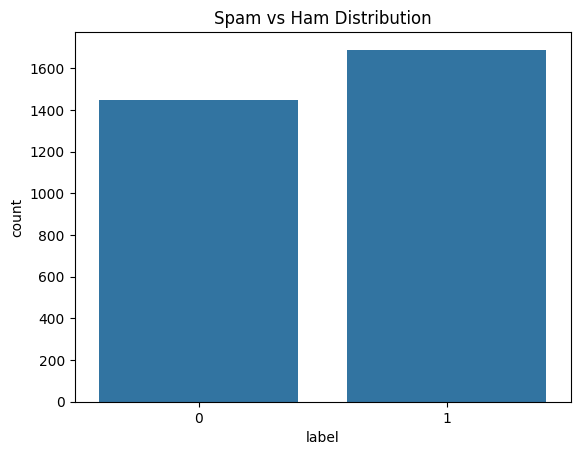

In [35]:
sns.countplot(x='label', data=df)
plt.title("Spam vs Ham Distribution")
plt.show()


In [36]:
df['label_name'] = df['label'].map({0: 'Ham', 1: 'Spam'})



# Email Length Analysis

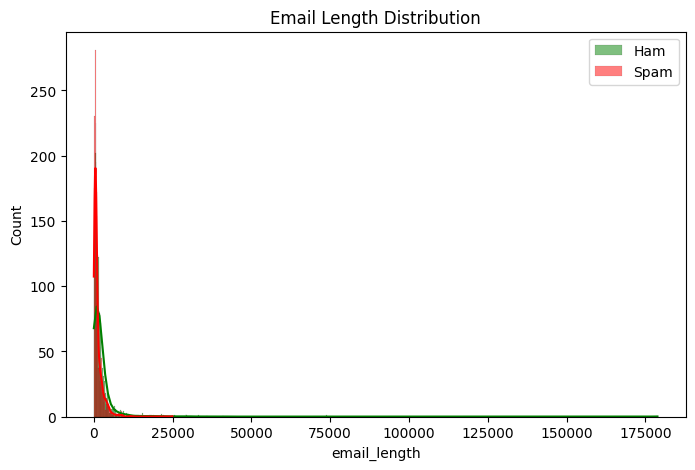

In [37]:
df['email_length'] = df['text'].apply(len)

plt.figure(figsize=(8,5))
sns.histplot(df[df['label']==0]['email_length'], label='Ham', color='green', kde=True)
sns.histplot(df[df['label']==1]['email_length'], label='Spam', color='red', kde=True)
plt.legend()
plt.title("Email Length Distribution")
plt.show()


# Text Cleaning Function

In [48]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text).strip()
    return text


In [39]:
df['clean_text'] = df['text'].apply(clean_text)


# Feature Extraction using TF-IDF

In [40]:
vectorizer = TfidfVectorizer(
    max_features=5000,
    stop_words='english'
)

X = vectorizer.fit_transform(df['clean_text'])
y = df['label']


In [41]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


# Naive Bayes

In [42]:
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

y_pred_nb = nb_model.predict(X_test)


In [43]:
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("Precision:", precision_score(y_test, y_pred_nb))
print("Recall:", recall_score(y_test, y_pred_nb))
print("F1 Score:", f1_score(y_test, y_pred_nb))


Accuracy: 0.9331210191082803
Precision: 0.9277456647398844
Recall: 0.9497041420118343
F1 Score: 0.9385964912280702


# Logistic Regression

In [44]:
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)

y_pred_lr = lr_model.predict(X_test)


In [45]:
print(classification_report(y_test, y_pred_lr))


              precision    recall  f1-score   support

           0       0.97      0.91      0.94       290
           1       0.92      0.98      0.95       338

    accuracy                           0.94       628
   macro avg       0.95      0.94      0.94       628
weighted avg       0.95      0.94      0.94       628



# Confusion Matrix

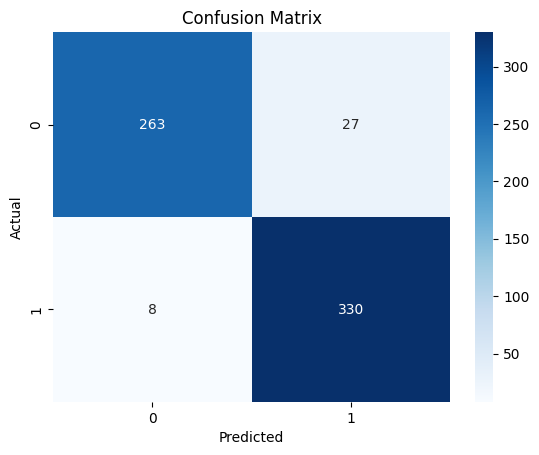

In [46]:
cm = confusion_matrix(y_test, y_pred_lr)

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [47]:
import joblib

joblib.dump(lr_model, "spam_classifier.pkl")
joblib.dump(vectorizer, "tfidf_vectorizer.pkl")


['tfidf_vectorizer.pkl']

In [49]:
import joblib

model = joblib.load("spam_classifier.pkl")
vectorizer = joblib.load("tfidf_vectorizer.pkl")


In [58]:
def predict_email(email_text):
    email_text = clean_text(email_text)

    email_vector = vectorizer.transform([email_text])

    prediction = model.predict(email_vector)[0]
    probability = model.predict_proba(email_vector)[0]

    return {
        "Prediction": "Spam" if prediction == 1 else "Ham",
        "Spam Probability": round(probability[1] * 100, 2),
        "Ham Probability": round(probability[0] * 100, 2)
    }


In [51]:
email_1 = """
Congratulations! You have won a $1000 Amazon gift card.
Click the link below to claim your reward now!!!
"""

predict_email(email_1)


{'Prediction': 'Spam',
 'Spam Probability': np.float64(82.78),
 'Ham Probability': np.float64(17.22)}

In [52]:
email_2 = """
Hi team,
Please find the attached report for last week's meeting.
Let me know if any changes are needed.
Thanks.
"""

predict_email(email_2)


{'Prediction': 'Ham',
 'Spam Probability': np.float64(17.46),
 'Ham Probability': np.float64(82.54)}

In [53]:
test_emails = [
    "Win a brand new iPhone now! Limited offer, click here",
    "Dear student, your exam schedule has been updated",
    "Lowest price Viagra available online. Order today!",
    "Let's meet tomorrow at 10 AM to discuss the project"
]

for email in test_emails:
    result = predict_email(email)
    print("Email:", email)
    print("Result:", result)
    print("-" * 60)


Email: Win a brand new iPhone now! Limited offer, click here
Result: {'Prediction': 'Spam', 'Spam Probability': np.float64(85.07), 'Ham Probability': np.float64(14.93)}
------------------------------------------------------------
Email: Dear student, your exam schedule has been updated
Result: {'Prediction': 'Ham', 'Spam Probability': np.float64(44.55), 'Ham Probability': np.float64(55.45)}
------------------------------------------------------------
Email: Lowest price Viagra available online. Order today!
Result: {'Prediction': 'Spam', 'Spam Probability': np.float64(94.34), 'Ham Probability': np.float64(5.66)}
------------------------------------------------------------
Email: Let's meet tomorrow at 10 AM to discuss the project
Result: {'Prediction': 'Ham', 'Spam Probability': np.float64(40.76), 'Ham Probability': np.float64(59.24)}
------------------------------------------------------------


In [54]:
predict_email("")


{'Prediction': 'Spam',
 'Spam Probability': np.float64(65.13),
 'Ham Probability': np.float64(34.87)}

In [55]:
predict_email("1234567890")


{'Prediction': 'Spam',
 'Spam Probability': np.float64(65.13),
 'Ham Probability': np.float64(34.87)}

In [56]:
predict_email("Hi, you have won free coupons but also meeting at 5")


{'Prediction': 'Spam',
 'Spam Probability': np.float64(57.91),
 'Ham Probability': np.float64(42.09)}

In [57]:
while True:
    email = input("Enter email text (or type 'exit'): ")
    if email.lower() == "exit":
        break
    print(predict_email(email))


Enter email text (or type 'exit'): exit
